# 글자 단위 RNN(Char RNN)

### 글자 단위 RNN 언어 모델(Char RNNLM)

다운로드 링크 : http://www.gutenberg.org/files/11/11-0.txt

#### 1) 데이터에 대한 이해와 전처리

In [1]:
import numpy as np
from tensorflow.keras.utils import to_categorical

In [2]:
f = open('C:/Users/it/Downloads/dataset/11-0.txt', 'rb')
lines = []
for line in f:
    line = line.strip() # strip()을 통해 \r, \n을 제거한다.
    line = line.lower()
    line = line.decode('ascii', 'ignore') # \xe2\x80\x99 등과 같은 바이트 열 제거
    if len(line) > 0:
        lines.append(line)
f.close()

In [3]:
lines[:5]

['project gutenbergs alices adventures in wonderland, by lewis carroll',
 'this ebook is for the use of anyone anywhere at no cost and with',
 'almost no restrictions whatsoever.  you may copy it, give it away or',
 're-use it under the terms of the project gutenberg license included',
 'with this ebook or online at www.gutenberg.org']

In [4]:
text = ' '.join(lines)
print('문자열의 길이 또는 총 글자의 개수 : %d' %len(text))

문자열의 길이 또는 총 글자의 개수 : 158783


In [5]:
print(text[:200])

project gutenbergs alices adventures in wonderland, by lewis carroll this ebook is for the use of anyone anywhere at no cost and with almost no restrictions whatsoever.  you may copy it, give it away 


기존에는 중복을 제거한 단어들의 모음인 단어 집합(vocabulary)을 만들었으나, 이번에 만들 집합은 단어 집합이 아니라 글자 집합입니다.

In [6]:
char_vocab = sorted(list(set(text)))
vocab_size = len(char_vocab)
print('글자 집합의 크기 : {}'.format(vocab_size))

글자 집합의 크기 : 55


글자 집합에 인덱스를 부여하고 전부 출력

In [7]:
char_to_index = dict((c, i) for i, c in enumerate(char_vocab))
print(char_to_index)

{' ': 0, '!': 1, '#': 2, '$': 3, '%': 4, '(': 5, ')': 6, '*': 7, ',': 8, '-': 9, '.': 10, '/': 11, '0': 12, '1': 13, '2': 14, '3': 15, '4': 16, '5': 17, '6': 18, '7': 19, '8': 20, '9': 21, ':': 22, ';': 23, '?': 24, '@': 25, '[': 26, ']': 27, '_': 28, 'a': 29, 'b': 30, 'c': 31, 'd': 32, 'e': 33, 'f': 34, 'g': 35, 'h': 36, 'i': 37, 'j': 38, 'k': 39, 'l': 40, 'm': 41, 'n': 42, 'o': 43, 'p': 44, 'q': 45, 'r': 46, 's': 47, 't': 48, 'u': 49, 'v': 50, 'w': 51, 'x': 52, 'y': 53, 'z': 54}


In [8]:
index_to_char={}
for key, value in char_to_index.items():
    index_to_char[value] = key

Example) 샘플의 길이가 4라면 4개의 입력 글자 시퀀스로 부터 4개의 출력 글자 시퀀스를 예측. 즉, RNN의 time step은 4번  
appl -> pple  
appl은 train_X(입력 시퀀스), pple는 train_y(예측해야하는 시퀀스)에 저장한다.

In [9]:
seq_length = 60
n_samples = int(np.floor((len(text) - 1) / seq_length))
print('문장 샘플의 수 : {}'.format(n_samples))

문장 샘플의 수 : 2646


In [10]:
train_X = []
train_y = []

for i in range(n_samples):
    X_sample = text[i * seq_length : (i + 1) * seq_length]
    X_encoded = [char_to_index[c] for c in X_sample]
    train_X.append(X_encoded)
    
    y_sample = text[i * seq_length + 1: (i + 1) * seq_length + 1] # 1칸 쉬프트
    y_encoded = [char_to_index[c] for c in y_sample]
    train_y.append(y_encoded)

In [11]:
print(train_X[0])

[44, 46, 43, 38, 33, 31, 48, 0, 35, 49, 48, 33, 42, 30, 33, 46, 35, 47, 0, 29, 40, 37, 31, 33, 47, 0, 29, 32, 50, 33, 42, 48, 49, 46, 33, 47, 0, 37, 42, 0, 51, 43, 42, 32, 33, 46, 40, 29, 42, 32, 8, 0, 30, 53, 0, 40, 33, 51, 37, 47]


In [12]:
print(train_y[0])

[46, 43, 38, 33, 31, 48, 0, 35, 49, 48, 33, 42, 30, 33, 46, 35, 47, 0, 29, 40, 37, 31, 33, 47, 0, 29, 32, 50, 33, 42, 48, 49, 46, 33, 47, 0, 37, 42, 0, 51, 43, 42, 32, 33, 46, 40, 29, 42, 32, 8, 0, 30, 53, 0, 40, 33, 51, 37, 47, 0]


In [13]:
print(train_X[1])

[0, 31, 29, 46, 46, 43, 40, 40, 0, 48, 36, 37, 47, 0, 33, 30, 43, 43, 39, 0, 37, 47, 0, 34, 43, 46, 0, 48, 36, 33, 0, 49, 47, 33, 0, 43, 34, 0, 29, 42, 53, 43, 42, 33, 0, 29, 42, 53, 51, 36, 33, 46, 33, 0, 29, 48, 0, 42, 43, 0]


In [14]:
print(train_y[1])

[31, 29, 46, 46, 43, 40, 40, 0, 48, 36, 37, 47, 0, 33, 30, 43, 43, 39, 0, 37, 47, 0, 34, 43, 46, 0, 48, 36, 33, 0, 49, 47, 33, 0, 43, 34, 0, 29, 42, 53, 43, 42, 33, 0, 29, 42, 53, 51, 36, 33, 46, 33, 0, 29, 48, 0, 42, 43, 0, 31]


In [15]:
train_X = to_categorical(train_X)
train_y = to_categorical(train_y)

In [16]:
print('train_X의 크기(shape) : {}'.format(train_X.shape)) # 원-핫 인코딩
print('train_y의 크기(shape) : {}'.format(train_y.shape)) # 원-핫 인코딩

train_X의 크기(shape) : (2646, 60, 55)
train_y의 크기(shape) : (2646, 60, 55)


train_X와 train_y의 크기는 2,646 × 60 × 55 입니다.  

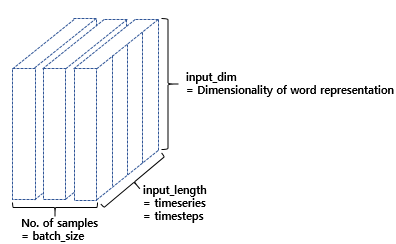


#### 2) 모델 설계하기

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed

In [20]:
model = Sequential()
model.add(LSTM(256, input_shape=(None, train_X.shape[2]), return_sequences=True))
model.add(LSTM(256, return_sequences=True))
model.add(TimeDistributed(Dense(vocab_size, activation='softmax')))

In [22]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(train_X, train_y, epochs=80, verbose=2)

Train on 2646 samples
Epoch 1/80
2646/2646 - 64s - loss: 3.0640 - accuracy: 0.1825
Epoch 2/80
2646/2646 - 57s - loss: 2.7357 - accuracy: 0.2468
Epoch 3/80
2646/2646 - 59s - loss: 2.3888 - accuracy: 0.3274
Epoch 4/80
2646/2646 - 45s - loss: 2.2478 - accuracy: 0.3591
Epoch 5/80
2646/2646 - 44s - loss: 2.1496 - accuracy: 0.3842
Epoch 6/80
2646/2646 - 44s - loss: 2.0698 - accuracy: 0.4024
Epoch 7/80
2646/2646 - 44s - loss: 2.0020 - accuracy: 0.4177
Epoch 8/80
2646/2646 - 44s - loss: 1.9422 - accuracy: 0.4340
Epoch 9/80
2646/2646 - 47s - loss: 1.8882 - accuracy: 0.4476
Epoch 10/80
2646/2646 - 46s - loss: 1.8403 - accuracy: 0.4615
Epoch 11/80
2646/2646 - 45s - loss: 1.7947 - accuracy: 0.4741
Epoch 12/80
2646/2646 - 44s - loss: 1.7492 - accuracy: 0.4865
Epoch 13/80
2646/2646 - 44s - loss: 1.7116 - accuracy: 0.4974
Epoch 14/80
2646/2646 - 44s - loss: 1.6699 - accuracy: 0.5087
Epoch 15/80
2646/2646 - 44s - loss: 1.6343 - accuracy: 0.5183
Epoch 16/80
2646/2646 - 45s - loss: 1.6016 - accuracy: 0.

In [25]:
def sentence_generation(model, length):
    ix = [np.random.randint(vocab_size)] # 글자에 대한 랜덤 인덱스 생성
    y_char = [index_to_char[ix[-1]]] # 랜덤 익덱스로부터 글자 생성
    print(ix[-1],'번 글자',y_char[-1],'로 예측을 시작!')
    X = np.zeros((1, length, vocab_size)) # (1, length, 55) 크기의 X 생성. 즉, LSTM의 입력 시퀀스 생성

    for i in range(length):
        X[0][i][ix[-1]] = 1 # X[0][i][예측한 글자의 인덱스] = 1, 즉, 예측 글자를 다음 입력 시퀀스에 추가
        print(index_to_char[ix[-1]], end="")
        ix = np.argmax(model.predict(X[:, :i+1, :])[0], 1)
        y_char.append(index_to_char[ix[-1]])
    return ('').join(y_char)

In [30]:
sentence_generation(model, 100)

19 번 글자 7 로 예측을 시작!
7 a large right distes of heardly in a very prodie-to--obrew, ho one of them attend! said alice very

'7 a large right distes of heardly in a very prodie-to--obrew, ho one of them attend! said alice very '

### 글자 단위 RNN(Char RNN)으로 텍스트 생성하기

#### 1) 데이터에 대한 이해와 전처리

In [36]:
import numpy as np
from tensorflow.keras.utils import to_categorical

In [37]:
text='''
I get on with life as a programmer,
I like to contemplate beer.
But when I start to daydream,
My mind turns straight to wine.

Do I love wine more than beer?

I like to use words about beer.
But when I stop my talking,
My mind turns straight to wine.

I hate bugs and errors.
But I just think back to wine,
And I'm happy once again.

I like to hang out with programming and deep learning.
But when left alone,
My mind turns straight to wine.
'''

In [38]:
text

"\nI get on with life as a programmer,\nI like to contemplate beer.\nBut when I start to daydream,\nMy mind turns straight to wine.\n\nDo I love wine more than beer?\n\nI like to use words about beer.\nBut when I stop my talking,\nMy mind turns straight to wine.\n\nI hate bugs and errors.\nBut I just think back to wine,\nAnd I'm happy once again.\n\nI like to hang out with programming and deep learning.\nBut when left alone,\nMy mind turns straight to wine.\n"

In [43]:
tokens = text.split()
text = ' '.join(tokens)
text

"I get on with life as a programmer, I like to contemplate beer. But when I start to daydream, My mind turns straight to wine. Do I love wine more than beer? I like to use words about beer. But when I stop my talking, My mind turns straight to wine. I hate bugs and errors. But I just think back to wine, And I'm happy once again. I like to hang out with programming and deep learning. But when left alone, My mind turns straight to wine."

In [45]:
char_vocab = sorted(list(set(text))) # 중복을 제거한 글자 집합 생성
print(char_vocab)

[' ', "'", ',', '.', '?', 'A', 'B', 'D', 'I', 'M', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'y']


In [46]:
vocab_size=len(char_vocab)
print ('글자 집합의 크기 : {}'.format(vocab_size))

글자 집합의 크기 : 33


In [47]:
char_to_index = dict((c, i) for i, c in enumerate(char_vocab))
print(char_to_index)

{' ': 0, "'": 1, ',': 2, '.': 3, '?': 4, 'A': 5, 'B': 6, 'D': 7, 'I': 8, 'M': 9, 'a': 10, 'b': 11, 'c': 12, 'd': 13, 'e': 14, 'f': 15, 'g': 16, 'h': 17, 'i': 18, 'j': 19, 'k': 20, 'l': 21, 'm': 22, 'n': 23, 'o': 24, 'p': 25, 'r': 26, 's': 27, 't': 28, 'u': 29, 'v': 30, 'w': 31, 'y': 32}


In [48]:
length = 11
sequences = []
for i in range(length, len(text)):
    seq = text[i - length : i]
    sequences.append(seq)
print('총 훈련 샘플의 수 : %d' %len(sequences))

총 훈련 샘플의 수 : 426


In [57]:
sequences[:5] # I get on with life as a programmer

['I get on wi', ' get on wit', 'get on with', 'et on with ', 't on with l']

In [55]:
X = []
for line in sequences:
    temp_X = [char_to_index[char] for char in line]
    X.append(temp_X)

In [56]:
for line in X[:5]:
    print(line)

[8, 0, 16, 14, 28, 0, 24, 23, 0, 31, 18]
[0, 16, 14, 28, 0, 24, 23, 0, 31, 18, 28]
[16, 14, 28, 0, 24, 23, 0, 31, 18, 28, 17]
[14, 28, 0, 24, 23, 0, 31, 18, 28, 17, 0]
[28, 0, 24, 23, 0, 31, 18, 28, 17, 0, 21]


In [58]:
sequences = np.array(X)
X = sequences[:, :-1]
y = sequences[:, -1]

In [59]:
for line in X[:5]:
    print(line)

[ 8  0 16 14 28  0 24 23  0 31]
[ 0 16 14 28  0 24 23  0 31 18]
[16 14 28  0 24 23  0 31 18 28]
[14 28  0 24 23  0 31 18 28 17]
[28  0 24 23  0 31 18 28 17  0]


In [60]:
print(y[:5])

[18 28 17  0 21]


In [61]:
sequences = [to_categorical(x, num_classes=vocab_size) for x in X]
X = np.array(sequences)
y = to_categorical(y, num_classes=vocab_size)

In [62]:
print(X.shape)

(426, 10, 33)


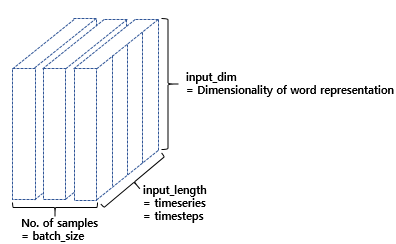

샘플의 수(No. of samples)가 426개, 입력 시퀀스의 길이(input_length)가 10, 각 벡터의 차원(input_dim)이 33임을 의미합니다.

#### 2) 모델 설계하기

In [63]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [65]:
model = Sequential()
model.add(LSTM(80, input_shape=(X.shape[1], X.shape[2])))
model.add(Dense(vocab_size, activation='softmax'))

In [67]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X, y, epochs=100, verbose=2)

Train on 426 samples
Epoch 1/100
426/426 - 3s - loss: 3.4620 - accuracy: 0.1244
Epoch 2/100
426/426 - 0s - loss: 3.2985 - accuracy: 0.1972
Epoch 3/100
426/426 - 0s - loss: 3.0556 - accuracy: 0.1972
Epoch 4/100
426/426 - 0s - loss: 2.9822 - accuracy: 0.1972
Epoch 5/100
426/426 - 0s - loss: 2.9519 - accuracy: 0.1972
Epoch 6/100
426/426 - 0s - loss: 2.9369 - accuracy: 0.1972
Epoch 7/100
426/426 - 0s - loss: 2.9157 - accuracy: 0.1972
Epoch 8/100
426/426 - 0s - loss: 2.9039 - accuracy: 0.1972
Epoch 9/100
426/426 - 0s - loss: 2.8828 - accuracy: 0.1972
Epoch 10/100
426/426 - 0s - loss: 2.8698 - accuracy: 0.1972
Epoch 11/100
426/426 - 0s - loss: 2.8305 - accuracy: 0.2089
Epoch 12/100
426/426 - 0s - loss: 2.8036 - accuracy: 0.2042
Epoch 13/100
426/426 - 0s - loss: 2.7633 - accuracy: 0.2113
Epoch 14/100
426/426 - 0s - loss: 2.7073 - accuracy: 0.2136
Epoch 15/100
426/426 - 0s - loss: 2.6624 - accuracy: 0.2770
Epoch 16/100
426/426 - 0s - loss: 2.6292 - accuracy: 0.2629
Epoch 17/100
426/426 - 0s - 

In [70]:
def sentence_generation(model, char_to_index, seq_length, seed_text, n):
    # 모델, 인덱스 정보, 문장 길이, 초기 시퀀스, 반복 횟수
    init_text = seed_text
    sentence = ''
    
    for _ in range(n):
        encoded = [char_to_index[char] for char in seed_text] # 현재 시퀀스에 대한 정수 인코딩
        encoded = pad_sequences([encoded], maxlen=seq_length, padding='pre') # 데이터에 대한 패딩
        encoded = to_categorical(encoded, num_classes=len(char_to_index))
        result = model.predict_classes(encoded, verbose=0)
        # 입력한 X(현재 시퀀스)에 대해서 y를 예측하고 y(예측한 글자)를 result에 저장.
        
        for char, index in char_to_index.items():
            if index == result:
                break
        seed_text = seed_text + char # 현재 시퀀스 + 예측 글자를 현재 시퀀스로 변경
        sentence = sentence + char # 예측 글자를 문장에 저장
         
    sentence = init_text + sentence
    return sentence

In [71]:
print(sentence_generation(model, char_to_index, 10, 'I get on w', 80))

I get on with life as a programmer, I like to csnt aoong time moon eenep. laanee, M Minnd 
